In [1]:
!pip install wordcloud==1.8.1 textblob==0.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 12.3 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import nltk
import plotly.express as px

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
# dataset loading
file_path_train = '/content/drive/My Drive/CS6120/project/drugsComTrain_raw.tsv'
train_df = pd.read_csv(file_path_train, sep='\t')

file_path_test = '/content/drive/My Drive/CS6120/project/drugsComTest_raw.tsv'
test_df = pd.read_csv(file_path_test, sep='\t')

print(train_df.head())
train_df.shape
print(test_df.head())
test_df.shape

   Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           1

(53766, 7)

In [76]:
# adding side effect dataset to assist sentiment labeling
file_path_side_effect = '/content/drive/My Drive/CS6120/project/meddra_all_se.tsv'
side_effect_df = pd.read_csv(file_path_side_effect, sep='\t', usecols=[5])  # only keep column 6 for side effect data

{'Drug-induced liver injury', 'Androgenetic alopecia', 'Vagotonia', 'Neurological symptom', 'IIIrd nerve paralysis', 'Retinal tear', 'Parathyroid tumour benign', 'Homozygous familial hypercholesterolaemia', 'Ascites', 'Decreased tolerance', 'Shock haemorrhagic', 'Peritoneal cloudy effluent', 'Cystitis', 'Spermatozoa abnormal', 'Hyperamylasaemia', 'Retinal toxicity', 'Sneezing', 'Hypertonic bladder', 'Chronic idiopathic constipation', 'Nephrolithiasis', 'Neuralgia', 'Meningism', 'Retinal vascular occlusion', 'Genitourinary chlamydia infection', 'Risus sardonicus', 'Transient ischaemic attack', 'Gastritis erosive', 'Antibody test negative', 'Pulse abnormal', 'Pulmonary embolism', 'Electrocardiogram QT prolonged', 'Vocal tic', 'Vaginal ulceration', 'Dropped beats', 'Acute overdose', 'Carbohydrate tolerance decreased', 'Collagen-vascular disease', 'Heat intolerance', 'Skin scaly', 'Direct bilirubin increased', 'Arcus juvenilis', 'Venous thromboembolism', 'Productive cough', 'Blood and lymp

# EDA

## Data overview

In [41]:
# Display dataset info
print(train_df.info())
print(train_df.describe())

# Check for missing values in the training and testing dataset
print(train_df.isnull().sum())
print(test_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB
None
          Unnamed: 0         rating    usefulCount
count  161297.000000  161297.000000  161297.000000
mean   115923.585305       6.994377      28.004755
std     67004.445170       3.272329      36.403742
min         2.000000       1.000000       0.000000
25%     58063.000000       5.000000       6.000000
50%    115744.000000       8.000000      16.000000
75%    173776.000000      10.000000      36.000000
max    232291.000000      10

## Data cleaning

In [42]:
# rather than just drop the non-value in condition, we choose to use the model to predict the condition value and fill in.
# but will do it later, right now we just drop it for now
train_df = train_df.dropna(subset=['condition'])
test_df = test_df.dropna(subset=['condition'])

In [7]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Variate Analysis: Univariate & Bivariate

#### Drug

In [8]:
# Count the number of unique drugs
unique_drugs = train_df['drugName'].nunique()
print(f"Total number of unique drugs in the dataset: {unique_drugs}")

Total number of unique drugs in the dataset: 3431


### Condition

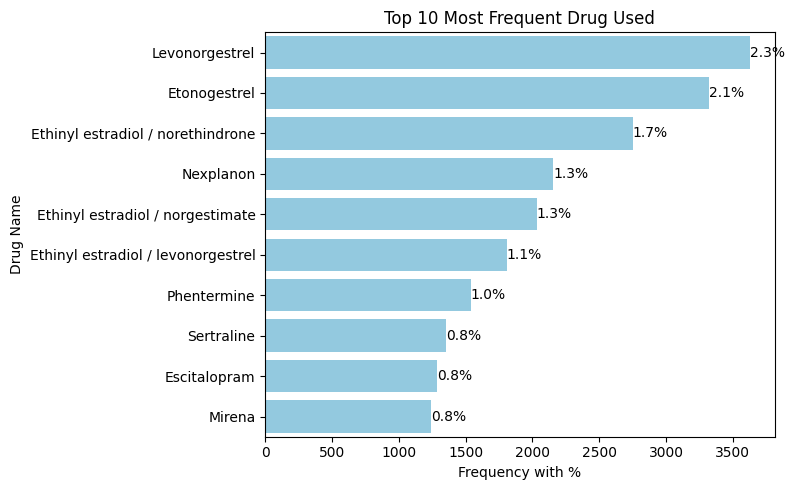

In [9]:
# Top 10 drugs used for reviews
top_10_drugs = train_df['drugName'].value_counts().head(10)

# Create the bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=top_10_drugs.values, y=top_10_drugs.index, color='skyblue')
plt.title('Top 10 Most Frequent Drug Used')
plt.ylabel('Drug Name')
plt.xlabel('Frequency with %')

# Add percentage labels
total = len(train_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_width() + 0.02
    y = p.get_y() + p.get_height() /2
    ax.annotate(percentage, (x, y), size=10,  va='center')

plt.tight_layout()
plt.show()

<ipython-input-10-914647ff9c20>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=condition_reviews.values, y=condition_reviews.index, palette="viridis")


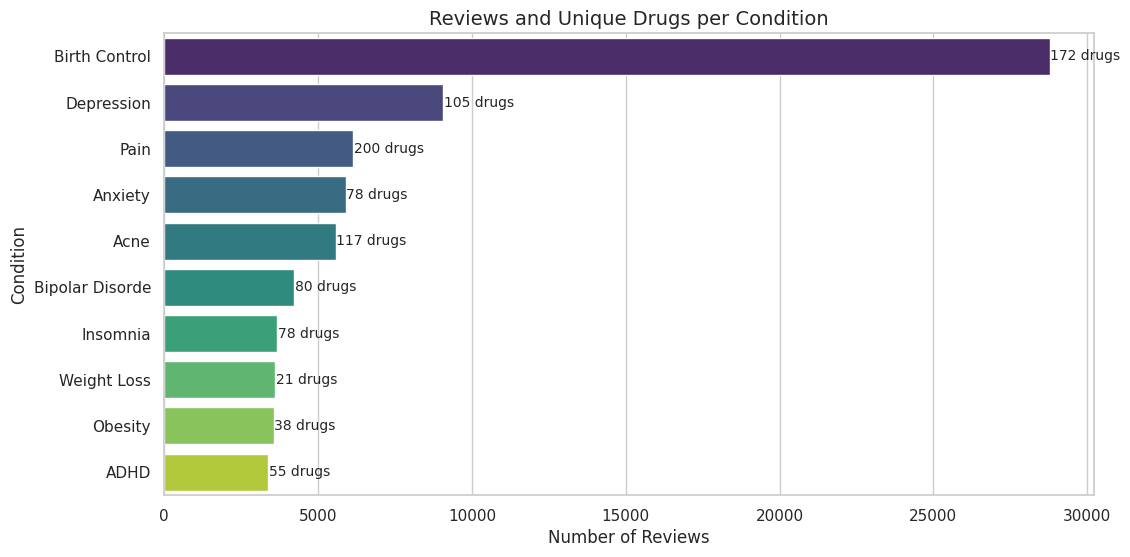

<ipython-input-10-914647ff9c20>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=drug_reviews.values, y=drug_reviews.index, palette="magma")


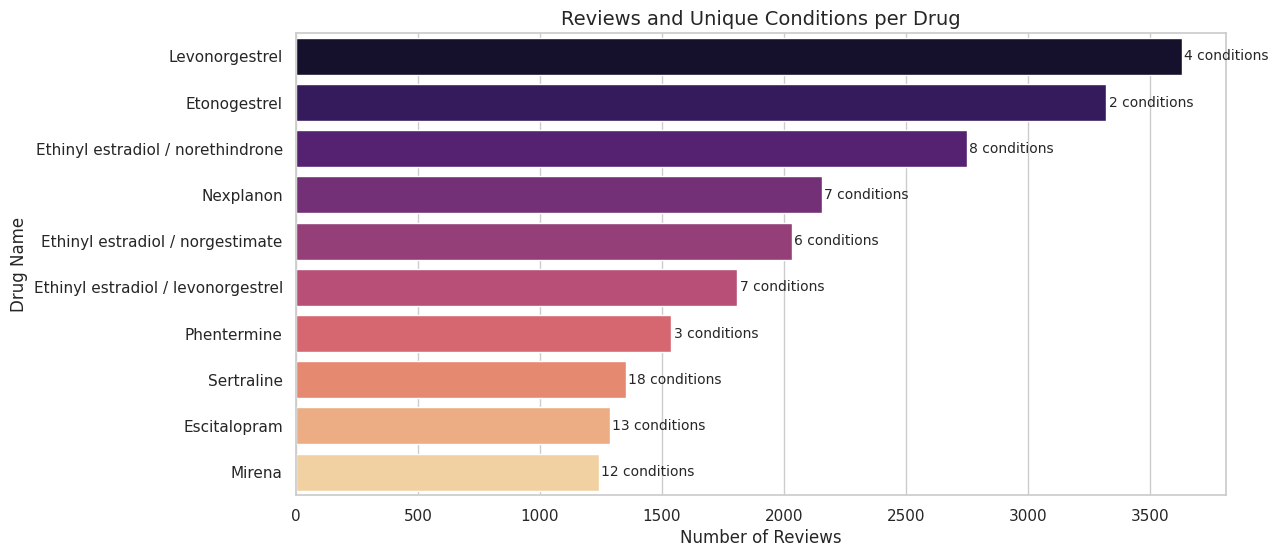

In [10]:
# Set aesthetics
sns.set(style="whitegrid")

# Top 10 conditions by reviews and unique drugs
top_conditions = train_df['condition'].value_counts().head(10).index
condition_reviews = train_df['condition'].value_counts().loc[top_conditions]
unique_drugs_per_condition = (
    train_df.groupby('condition')['drugName']
    .nunique()
    .loc[top_conditions]
)

# Plot: Reviews and Unique Drugs per Condition
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=condition_reviews.values, y=condition_reviews.index, palette="viridis")
for i, value in enumerate(unique_drugs_per_condition.values):
    ax.text(condition_reviews.values[i] + 10, i, f"{value} drugs", va="center", fontsize=10)
plt.title('Reviews and Unique Drugs per Condition', fontsize=14)
plt.xlabel('Number of Reviews')
plt.ylabel('Condition')
plt.show()

# Top 10 drugs by reviews and unique conditions
top_drugs = train_df['drugName'].value_counts().head(10).index
drug_reviews = train_df['drugName'].value_counts().loc[top_drugs]
unique_conditions_per_drug = (
    train_df.groupby('drugName')['condition']
    .nunique()
    .loc[top_drugs]
)

# Plot: Reviews and Unique Conditions per Drug
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=drug_reviews.values, y=drug_reviews.index, palette="magma")
for i, value in enumerate(unique_conditions_per_drug.values):
    ax.text(drug_reviews.values[i] + 10, i, f"{value} conditions", va="center", fontsize=10)
plt.title('Reviews and Unique Conditions per Drug', fontsize=14)
plt.xlabel('Number of Reviews')
plt.ylabel('Drug Name')
plt.show()

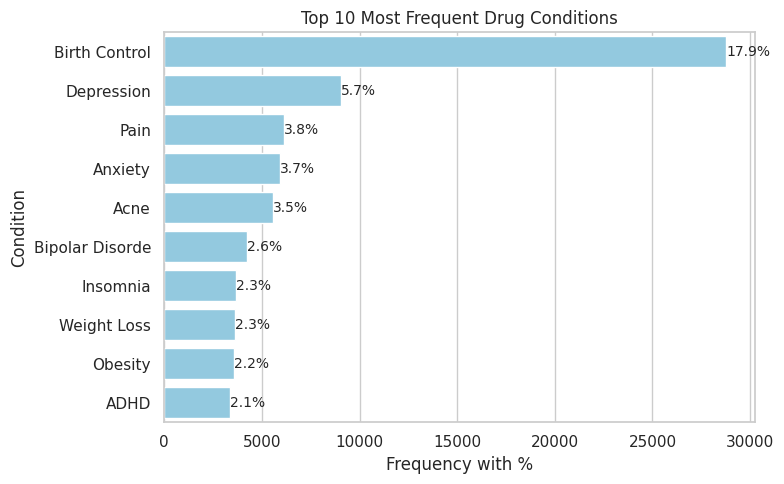

In [11]:
# condition with reviews
# Filter top 10 conditions
top_10_conditions = train_df['condition'].value_counts().nlargest(10)
top_conditions = top_10_conditions.index

# Create the bar chart using seaborn
plt.figure(figsize=(8, 5))
ax = sns.barplot(y=top_10_conditions.index, x=top_10_conditions.values, color='skyblue', orient='h')
plt.title('Top 10 Most Frequent Drug Conditions')
plt.ylabel('Condition')
plt.xlabel('Frequency with %')

total = len(train_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), size=10, va='center')

plt.tight_layout()
plt.show()

### Bivariate Analysis: rating vs. condition

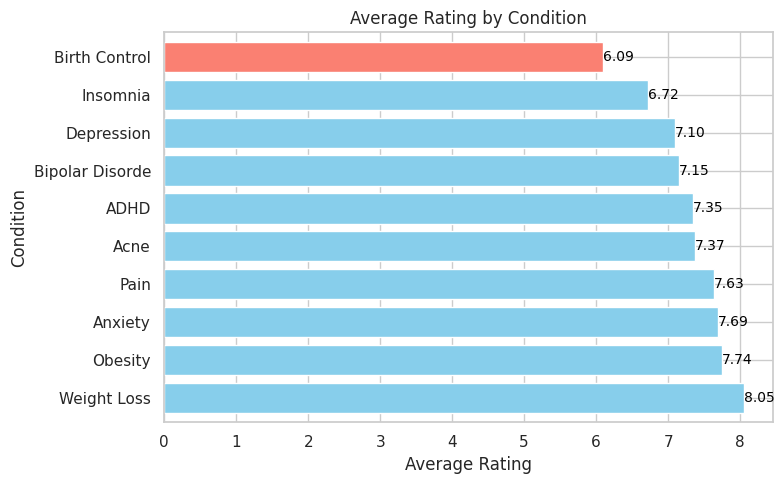

In [12]:
# Average rating by condition (top 10 conditions)
condition_rating = train_df[train_df['condition'].isin(top_conditions)]
avg_rating_by_condition = condition_rating.groupby('condition')['rating'].mean().sort_values(ascending=False)

# Highlight 'Birth Control'
highlight_color = 'salmon'
default_color = 'skyblue'
bar_colors = [highlight_color if condition == 'Birth Control' else default_color for condition in avg_rating_by_condition.index]

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = avg_rating_by_condition.plot(kind='barh', color=bar_colors, title="Average Rating by Condition", width=0.8)
plt.ylabel("Condition")
plt.xlabel("Average Rating")

for bar in bars.patches:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.2f}',
        ha='left', va='center', fontsize=10, color='black'
    )

plt.tight_layout()
plt.show()

### Rating

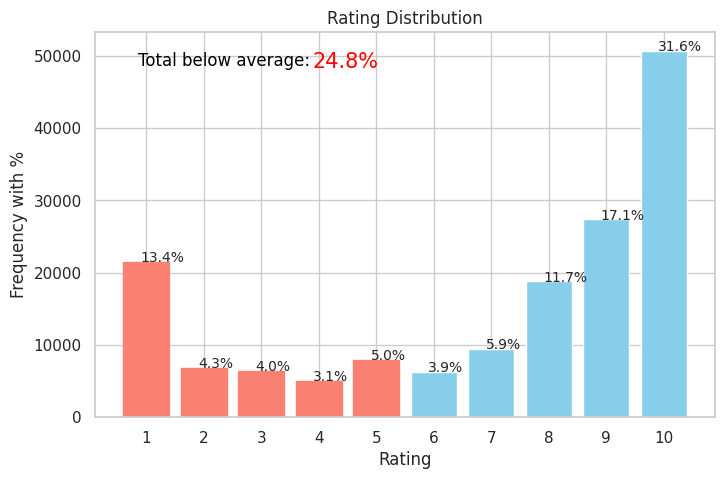

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique ratings and their frequencies
ratings, frequencies = np.unique(train_df['rating'], return_counts=True)

# Create the bar chart
plt.figure(figsize=(8, 5))
ax = plt.bar(ratings, frequencies, color='skyblue')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency with %")
plt.xticks(ratings)

# Add percentage labels
total = len(train_df)
for i, p in enumerate(ax):  # Enumerate to get index and bar object
    percentage = '{:.1f}%'.format(100 * frequencies[i] / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 0.01
    plt.annotate(percentage, (x, y), size=10)  # Annotate with percentage

# Highlight bars below 5
for i, p in enumerate(ax):
    if ratings[i] <= 5:
        p.set_color('salmon')  # Change color to salmon for ratings below 5

# Calculate and display total percentage below 5
total_below_5 = np.sum(frequencies[ratings < 5])  # Sum frequencies for ratings below 5
total_percentage_below_5 = '{:.1f}%'.format(100 * total_below_5 / total)

# Add annotation
plt.annotate(f"Total below average:",
             xy=(0.07, 0.95), xycoords='axes fraction',
             ha='left', va='top', fontsize=12,
             color='black')  # Set overall annotation color to black

# Highlight the percentage value in red
plt.annotate(total_percentage_below_5,  # Text to highlight
             xy=(0.35, 0.95), xycoords='axes fraction',
             ha='left', va='top', fontsize=15,
             color='red')  # Set highlighted text color to red

plt.show()

In [14]:
# Although many people tend to give a score of 10 with satisfied,
# we cannot ignore that almost 25% of patients score below the average.

In [15]:
# maybe analyze the usefulCount (numerical): number of users who found review useful
# as the weighted for each record
# the more useful, the more weighted it takes
# do it later

### Bivariate Analysis: usefulCount vs. rating

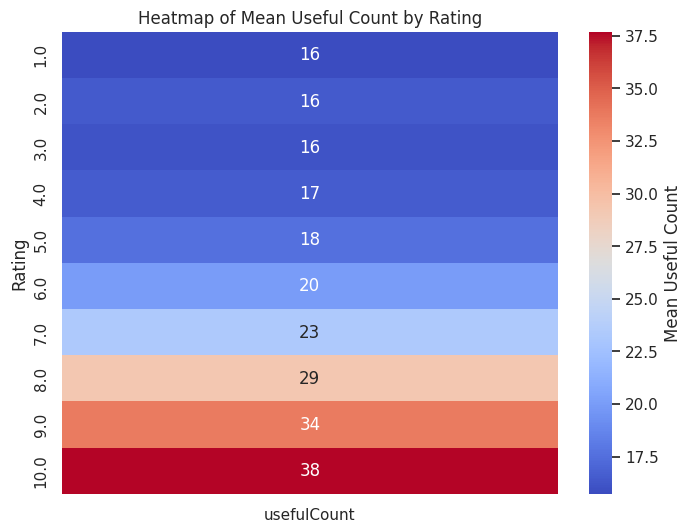

In [16]:
from matplotlib.colors import LinearSegmentedColormap

# Create a pivot table to aggregate usefulCount by rating
heatmap_data = train_df.pivot_table(values='usefulCount', index='rating', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', cbar_kws={'label': 'Mean Useful Count'})
plt.title('Heatmap of Mean Useful Count by Rating')
#plt.xlabel('Rating')
plt.ylabel('Rating')
plt.show()

In [17]:
# heatmap shows, in general, reviews with higher ratings tend to have a higher average 'usefulCount'.
# This implies that users find reviews with higher ratings more helpful.

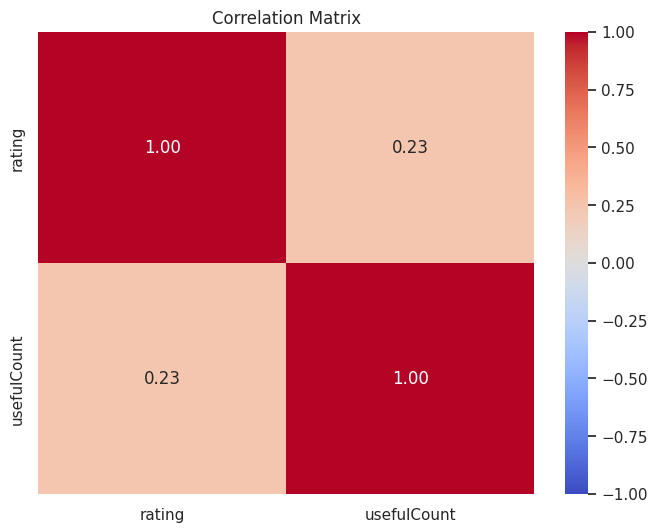

In [18]:
num_features = ['rating', 'usefulCount']
corr_matrix = train_df[num_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [19]:
filtered_data = train_df[train_df['condition'].isin(top_conditions)]

# Aggregate reviews and ratings for conditions
condition_stats = filtered_data.groupby('condition').agg(
    total_reviews=('review', 'size'),
    total_drugs=('drugName', 'nunique'),
    avg_rating=('rating', 'mean')
).reset_index()

# Rename columns in condition_stats to distinguish them
condition_stats = condition_stats.rename(columns={
    'total_reviews': 'total_reviews_condition',
    'total_drugs': 'total_drugs_condition',
    'avg_rating': 'avg_rating_condition'
})

# Aggregate reviews and ratings for drugs within conditions
drug_stats = filtered_data.groupby(['condition', 'drugName']).agg(
    reviews=('review', 'size'),
    avg_rating=('rating', 'mean')
).reset_index()

# Merge condition-level stats into drug-level stats
drug_stats = drug_stats.merge(condition_stats, on='condition', how='left')

# Calculate percentages
drug_stats['percent_in_condition'] = (drug_stats['reviews'] / drug_stats['total_reviews_condition'] * 100).round(2)
drug_stats['percent_in_all'] = (drug_stats['reviews'] / train_df.shape[0] * 100).round(2)

# Add custom hover data for the treemap
drug_stats['extra_info'] = (
    "Condition: " + drug_stats['condition'] +
    "<br>Drugs: " + drug_stats['total_drugs_condition'].astype(str) +
    "<br>Reviews in Condition: " + drug_stats['total_reviews_condition'].astype(str) +
    "<br>Average Rating in Condition: " + drug_stats['avg_rating_condition'].round(2).astype(str) +
    "<br>" +
    "<br>Drug: " + drug_stats['drugName'] +
    "<br>Reviews for Drug: " + drug_stats['reviews'].astype(str) +
    "<br>Average Rating for Drug: " + drug_stats['avg_rating'].round(2).astype(str) +
    "<br>% in " + drug_stats['condition'] + ": " + drug_stats['percent_in_condition'].astype(str) + "%" +
    "<br>% in All Conditions: " + drug_stats['percent_in_all'].astype(str) + "%"
)

fig = px.treemap(
    drug_stats,
    path=['condition', 'drugName'],  # Define hierarchy: Condition -> Drug
    values='reviews',               # Size based on number of reviews
    title="Hierarchy of Conditions and Drugs with Customized Labels",
    color='reviews',                # Color based on number of reviews
    color_continuous_scale='orrd',
    custom_data=['extra_info']      # Add extra information for hover
)

# Customize the hovertemplate
fig.update_traces(
    hovertemplate="%{customdata[0]}"  # Use custom data for the tooltip
)

fig.show()

In [20]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    " ".join(train_df['review'])
)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Reviews")
plt.show()

# word cloud is a powerful tool, use it later

KeyboardInterrupt: 

## Data preprocessing

### Text analysis

#### Tokenization and Text Normalization

In [21]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [43]:
import re
from nltk.tokenize import word_tokenize

# Tokenization and Text Normalization
def normalize_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    return tokens

train_df['normalized_review'] = train_df['review'].astype(str).apply(normalize_text)
test_df['normalized_review'] = test_df['review'].astype(str).apply(normalize_text)

In [23]:
print(train_df[['review', 'normalized_review']].head())

                                              review  \
0  "It has no side effect, I take it in combinati...   
1  "My son is halfway through his fourth week of ...   
2  "I used to take another oral contraceptive, wh...   
3  "This is my first time using any form of birth...   
4  "Suboxone has completely turned my life around...   

                                   normalized_review  
0  [it, has, no, side, effect, i, take, it, in, c...  
1  [my, son, is, halfway, through, his, fourth, w...  
2  [i, used, to, take, another, oral, contracepti...  
3  [this, is, my, first, time, using, any, form, ...  
4  [suboxone, has, completely, turned, my, life, ...  


In [24]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#### Removing Stopwords and Lemmatization

In [25]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [46]:
# Load stopwords
stop_words = set(stopwords.words('english'))
# Define negation words
negation_words = {'against', "no", "not", "don't", "doesn't", "didn't", "wasn't", "weren't", "isn't", "aren't", "haven't", "hasn't", "hadn't", "won't", "wouldn't", "shan't", "shouldn't", "can't", "couldn't", "mustn't", "mightn't", 'aren', 'couldn', 'didn','doesn','don','hadn','hasn', 'haven', 'isn', 'mightn', 'mustn','needn', "needn't", 'nor','shan','shouldn', 'wasn','weren','wouldn' }

stop_words_without_negation = stop_words - negation_words
stop_words_without_negation

{'a',
 'about',
 'above',
 'after',
 'again',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'd',
 'did',
 'do',
 'does',
 'doing',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'has',
 'have',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'more',
 'most',
 'my',
 'myself',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'she',
 "she's",
 'should',
 "should've",
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'too',
 'under',
 'until',
 'up',


In [47]:
# remove stopwords
def preprocess_tokens(tokens):
    # Remove stopwords, excluding negation words
    tokens = [word for word in tokens if word not in stop_words_without_negation]
    return tokens

# Apply preprocessing to normalized tokens
train_df['processed_review'] = train_df['normalized_review'].apply(preprocess_tokens)
test_df['processed_review'] = test_df['normalized_review'].apply(preprocess_tokens)

In [48]:
print(train_df[['review', 'processed_review']].head())

                                              review  \
0  "It has no side effect, I take it in combinati...   
1  "My son is halfway through his fourth week of ...   
2  "I used to take another oral contraceptive, wh...   
3  "This is my first time using any form of birth...   
4  "Suboxone has completely turned my life around...   

                                    processed_review  
0  [no, side, effect, take, combination, bystolic...  
1  [son, halfway, fourth, week, intuniv, became, ...  
2  [used, take, another, oral, contraceptive, pil...  
3  [first, time, using, form, birth, control, im,...  
4  [suboxone, completely, turned, life, around, f...  


In [49]:
train_df.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  \
0       May 20, 2012           27   
1     April 27, 2010          192   
2  December 14, 2009           17   
3   November 3, 2015           10   
4  November 27, 2016           37   

                                   normalized_review  \
0  [it, has, no, side, effect, i, take, it, in, c...   
1  [my, son, is, halfway, through, his, fourth, w...   
2  [i, used, to, take, another, oral, contracepti...   
3  [this, is, my, first, time, using, any, form, ...   
4  [suboxone, has, completely, turned, my, life, ...   

                                    processed_review  
0  [no, side, effect, take, combination, bystolic...  
1  [son, halfway, fourth, week, intuniv, became, ...  
2  [used, take, another, oral, contraceptive, pil...  
3  [first, time, using, form, birth, control, im,...  
4  [suboxone, completely, turned, life, around, f...

In [50]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(tokens)  # Get part-of-speech tags for each token

    # Lemmatize each token based on its POS tag
    lemmas = []
    for word, tag in pos_tags:
        wordnet_tag = get_wordnet_pos(tag)
        if wordnet_tag is not None:
            lemma = lemmatizer.lemmatize(word, pos=wordnet_tag)
        else:
            lemma = word
        lemmas.append(lemma)

    return lemmas

# Helper function to map POS tag to WordNet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Apply the lemmatization to the 'processed_review' column
train_df['lemmatized_review'] = train_df['processed_review'].apply(lemmatize_tokens)

print(train_df[['processed_review', 'lemmatized_review']].head())

                                    processed_review  \
0  [no, side, effect, take, combination, bystolic...   
1  [son, halfway, fourth, week, intuniv, became, ...   
2  [used, take, another, oral, contraceptive, pil...   
3  [first, time, using, form, birth, control, im,...   
4  [suboxone, completely, turned, life, around, f...   

                                   lemmatized_review  
0  [no, side, effect, take, combination, bystolic...  
1  [son, halfway, fourth, week, intuniv, become, ...  
2  [use, take, another, oral, contraceptive, pill...  
3  [first, time, use, form, birth, control, im, g...  
4  [suboxone, completely, turn, life, around, fee...  


In [51]:
train_df.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  \
0       May 20, 2012           27   
1     April 27, 2010          192   
2  December 14, 2009           17   
3   November 3, 2015           10   
4  November 27, 2016           37   

                                   normalized_review  \
0  [it, has, no, side, effect, i, take, it, in, c...   
1  [my, son, is, halfway, through, his, fourth, w...   
2  [i, used, to, take, another, oral, contracepti...   
3  [this, is, my, first, time, using, any, form, ...   
4  [suboxone, has, completely, turned, my, life, ...   

                                    processed_review  \
0  [no, side, effect, take, combination, bystolic...   
1  [son, halfway, fourth, week, intuniv, became, ...   
2  [used, take, another, oral, contraceptive, pil...   
3  [first, time, using, form, birth, control, im,...   
4  [suboxone, completely, turned, life, around, f...   

                                   lemmatized_review  
0  [no, side, effect, take, combination, bystolic...  
1  [son, halfway, fourth, week, intuniv, become, ...  
2  [use, take, another, oral, contraceptive, pill...  
3  [first, time, use, form, birth, control, im, g...  
4  [suboxone, completely, turn, life, around, fee...

from matplotlib import pyplot as plt
_df_0['Unnamed: 0'].plot(kind='hist', bins=20, title='Unnamed: 0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['usefulCount'].plot(kind='hist', bins=20, title='usefulCount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('drugName').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('condition').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning:

) missing from current font.



from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('review').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Unnamed: 0', y='rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='rating', y='usefulCount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Unnamed: 0']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('drugName')):
  _plot_series(series, series_name, i)
  fig.legend(title='drugName', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Unnamed: 0')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Unnamed: 0']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('condition')):
  _plot_series(series, series_name, i)
  fig.legend(title='condition', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Unnamed: 0')

/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning:

) missing from current font.



from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Unnamed: 0']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('review')):
  _plot_series(series, series_name, i)
  fig.legend(title='review', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Unnamed: 0')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Unnamed: 0']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('date')):
  _plot_series(series, series_name, i)
  fig.legend(title='date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Unnamed: 0')

from matplotlib import pyplot as plt
_df_13['Unnamed: 0'].plot(kind='line', figsize=(8, 4), title='Unnamed: 0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['usefulCount'].plot(kind='line', figsize=(8, 4), title='usefulCount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['condition'].value_counts()
    for x_label, grp in _df_16.groupby('drugName')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('drugName')
_ = plt.ylabel('condition')

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning:

) missing from current font.

/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning:

) missing from current font.



from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['review'].value_counts()
    for x_label, grp in _df_17.groupby('condition')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('condition')
_ = plt.ylabel('review')

/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning:

) missing from current font.

/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning:

) missing from current font.



from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['date'].value_counts()
    for x_label, grp in _df_18.groupby('review')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('review')
_ = plt.ylabel('date')

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['drugName'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Unnamed: 0', y='drugName', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['condition'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Unnamed: 0', y='condition', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.10/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning:

) missing from current font.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['review'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='Unnamed: 0', y='review', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='Unnamed: 0', y='date', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Sentiment labeling

#### SIDER side effect dataset
find the side effect in each drug group by using side effect dataset

In [79]:
# make a set to store all words (potentially side effect words) into a set
# Create an empty set to store all words
all_words = set()

# Iterate through each record in the 'lemmatized_review' column
for review_words in train_df['lemmatized_review']:
    # Add each word to the set
    all_words.update(review_words)

# Print the total number of unique words in the set
print(f"Total number of unique words: {len(all_words)}")
all_words

Total number of unique words: 65580


{'lipsface',
 'timesdid',
 'fasttracked',
 'benedrly',
 'limpia',
 'zombierobot',
 'gothanks',
 'daysive',
 'scription',
 'spit',
 'underweight',
 'quotbacked',
 'vomitted',
 'sophomorejunior',
 'shots',
 'incomprehensiblegiven',
 'funeral',
 'haste',
 'vertebrea',
 'quandary',
 'nightnow',
 'juvenile',
 'neutropenia',
 'cabergoline',
 'northstar',
 'quotinternal',
 'elsejust',
 'itrsquod',
 'calcium',
 'seldom',
 'hahahar',
 'reduceses',
 'semiunprotected',
 'jawchin',
 'spondylolisthesis',
 'establish',
 'investigative',
 'referencing',
 'fcas',
 'astellas',
 'diagnostic',
 'likewowits',
 'behing',
 'extract',
 'bleedingwith',
 'cunning',
 'drugsthe',
 'drugsave',
 'sticky',
 'album',
 'trazodonelast',
 'ineffectivebecause',
 'unnerve',
 'gallbaldder',
 'sandexa',
 'urelle',
 'stressrelatedquot',
 'monthbefore',
 'fibreaucun',
 'asperger',
 'nausious',
 'magical',
 'saidjust',
 'kebab',
 'woulf',
 'irrated',
 'expectedi',
 'lifecardiologist',
 'eutirox',
 'quotpainquot',
 'tolterodin

In [82]:
# Keep only unique values as a set
unique_side_effect = set(side_effect_df.iloc[:, 0].unique())

print(unique_side_effect)
print(f"Total number of unique side effect: {len(unique_side_effect)}")

{'Drug-induced liver injury', 'Androgenetic alopecia', 'Vagotonia', 'Neurological symptom', 'IIIrd nerve paralysis', 'Retinal tear', 'Parathyroid tumour benign', 'Homozygous familial hypercholesterolaemia', 'Ascites', 'Decreased tolerance', 'Shock haemorrhagic', 'Peritoneal cloudy effluent', 'Cystitis', 'Spermatozoa abnormal', 'Hyperamylasaemia', 'Retinal toxicity', 'Sneezing', 'Hypertonic bladder', 'Chronic idiopathic constipation', 'Nephrolithiasis', 'Neuralgia', 'Meningism', 'Retinal vascular occlusion', 'Genitourinary chlamydia infection', 'Risus sardonicus', 'Transient ischaemic attack', 'Gastritis erosive', 'Antibody test negative', 'Pulse abnormal', 'Pulmonary embolism', 'Electrocardiogram QT prolonged', 'Vocal tic', 'Vaginal ulceration', 'Dropped beats', 'Acute overdose', 'Carbohydrate tolerance decreased', 'Collagen-vascular disease', 'Heat intolerance', 'Skin scaly', 'Direct bilirubin increased', 'Arcus juvenilis', 'Venous thromboembolism', 'Productive cough', 'Blood and lymp

In [83]:
# Keep only single-word entries and lower all characters
unique_side_effect = {word.lower() for word in unique_side_effect if len(word.split()) == 1}
print(unique_side_effect)
print(f"Total number of unique words in the updated set: {len(unique_side_effect)}")

{'hypothrombinaemia', 'phenylketonuria', 'osteochondrosis', 'acne', 'vt', 'xanthopsia', 'metastasis', 'anhedonia', 'underweight', 'suspiciousness', 'leukoplakia', 'adenomyosis', 'lipoatrophy', 'azoospermia', 'dysmenorrhoea', 'prehypertension', 'aspermia', 'ascariasis', 'neutrophilia', 'acidosis', 'strangulation', 'atelectasis', 'balanoposthitis', 'nausea', 'gastrooesophagitis', 'oedema', 'concussion', 'hyperamylasaemia', 'reticuloendotheliosis', 'hemianopia', 'hypocalcaemia', 'lymphadenopathy', 'hypercalciuria', 'hypophosphataemia', 'neutropenia', 'clubbing', 'phlebitis', 'keratopathy', 'myelofibrosis', 'malnutrition', 'epiglottitis', 'abasia', 'aneurysm', 'stomatitis', 'bronchitis', 'nephrotoxicity', 'phobia', 'papilloma', 'metrorrhagia', 'vagotonia', 'exophthalmos', 'acetonaemia', 'claustrophobia', 'hyperaemia', 'retinitis', 'monoplegia', 'polyp', 'hypoxemia', 'dependence', 'anthrax', 'enterocolitis', 'gagging', 'osteosclerosis', 'paronychia', 'exhaustion', 'bradykinesia', 'maculopat

In [84]:
# use unique_side_effect and all_words sets to find the intersection side effects

# Find the intersection (common words)
drug_side_effect = list(unique_side_effect.intersection(all_words))

print(drug_side_effect)
print(f"Number of common words: {len(drug_side_effect)}")

['acne', 'vt', 'anhedonia', 'metastasis', 'underweight', 'suspiciousness', 'prehypertension', 'atelectasis', 'acidosis', 'nausea', 'oedema', 'concussion', 'lymphadenopathy', 'neutropenia', 'phlebitis', 'myelofibrosis', 'malnutrition', 'aneurysm', 'bronchitis', 'phobia', 'papilloma', 'claustrophobia', 'polyp', 'dependence', 'anthrax', 'gagging', 'paronychia', 'exhaustion', 'appendicitis', 'vomiting', 'arteritis', 'mastocytosis', 'hernia', 'pertussis', 'myelitis', 'thrombophlebitis', 'comedone', 'purpura', 'sprain', 'battery', 'dizziness', 'stiffness', 'gastritis', 'fertilization', 'akathisia', 'shock', 'sunburn', 'unsteadiness', 'bradycardia', 'sluggishness', 'nephropathy', 'gastroenteritis', 'paresis', 'pica', 'atopy', 'agitation', 'fracture', 'folliculitis', 'pyelonephritis', 'swelling', 'aggression', 'pemphigus', 'accident', 'hyperacusis', 'angioedema', 'glossitis', 'hepatitis', 'cholecystitis', 'scald', 'hypervigilance', 'headache', 'phonophobia', 'delirium', 'laryngospasm', 'milia'

In [87]:
# Assuming you have the drug_side_effect set and train_df DataFrame

drug_side_effect_dict = {}  # Initialize an empty dictionary

for index, row in train_df.iterrows():
    drug_name = row['drugName']
    lemmatized_review = row['lemmatized_review']

    side_effects_for_drug = set()
    for side_effect in drug_side_effect:
        if side_effect in lemmatized_review:
            side_effects_for_drug.add(side_effect)

    drug_side_effect_dict[drug_name] = side_effects_for_drug or None

print(drug_side_effect_dict)

{'Valsartan': {'stress', 'surgery'}, 'Guanfacine': None, 'Lybrel': None, 'Ortho Evra': None, 'Buprenorphine / naloxone': {'constipation'}, 'Cialis': None, 'Levonorgestrel': {'pain'}, 'Aripiprazole': {'schizophrenia'}, 'Keppra': {'constipation'}, 'Ethinyl estradiol / levonorgestrel': None, 'Topiramate': {'bedridden', 'pain', 'ache', 'fibromyalgia'}, 'L-methylfolate': {'depression', 'anxiety', 'surgery'}, 'Pentasa': {'gas', 'pain'}, 'Dextromethorphan': {'cough'}, 'Nexplanon': None, 'Liraglutide': None, 'Trimethoprim': {'infection'}, 'Amitriptyline': {'pregnancy', 'cystitis', 'pain'}, 'Lamotrigine': {'depression'}, 'Nilotinib': {'redness'}, 'Atripla': None, 'Trazodone': {'depression'}, 'Etonogestrel': {'depression', 'fatigue'}, 'Etanercept': {'psoriasis'}, 'Tioconazole': {'burn', 'fall'}, 'Azithromycin': {'dizziness'}, 'Eflornithine': {'depression'}, 'Daytrana': {'autism'}, 'Ativan': {'depression', 'anxiety'}, 'Imitrex': {'migraine', 'nausea'}, 'Sertraline': {'depression', 'nausea'}, 'Tor

In [93]:
# Show drugs only with their side effects mentioned
drug_side_effect_show = {k: v for k, v in drug_side_effect_dict.items() if v is not None}
len(drug_side_effect_show)

1921

In [95]:
# save drug_side_effect_dict to csv for showing
import csv

with open('drug_side_effects.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Drug Name', 'Side Effects'])  # Write header row
    for drug_name, side_effects in drug_side_effect_dict.items():
        # If side_effects is not None, join the elements with ', ' otherwise write None
        side_effects_str = ', '.join(side_effects) if side_effects else None
        writer.writerow([drug_name, side_effects_str])

In [96]:
# calculate how many times mentioned in review for each side effects
side_effect_counts = {}  # Initialize a dictionary to store counts

for side_effect in drug_side_effect:
    count = 0
    for review in train_df['review']:
        if side_effect in review.lower():
            count += 1
    side_effect_counts[side_effect] = count

side_effect_counts_df = pd.DataFrame(list(side_effect_counts.items()), columns=['Side Effect', 'Count'])
print(side_effect_counts_df)

     Side Effect  Count
0           acne  11258
1             vt    163
2      anhedonia     29
3     metastasis     30
4    underweight     98
..           ...    ...
512       crying   2287
513          gas   2695
514   urethritis      2
515    nightmare   1770
516   duodenitis      2

[517 rows x 2 columns]


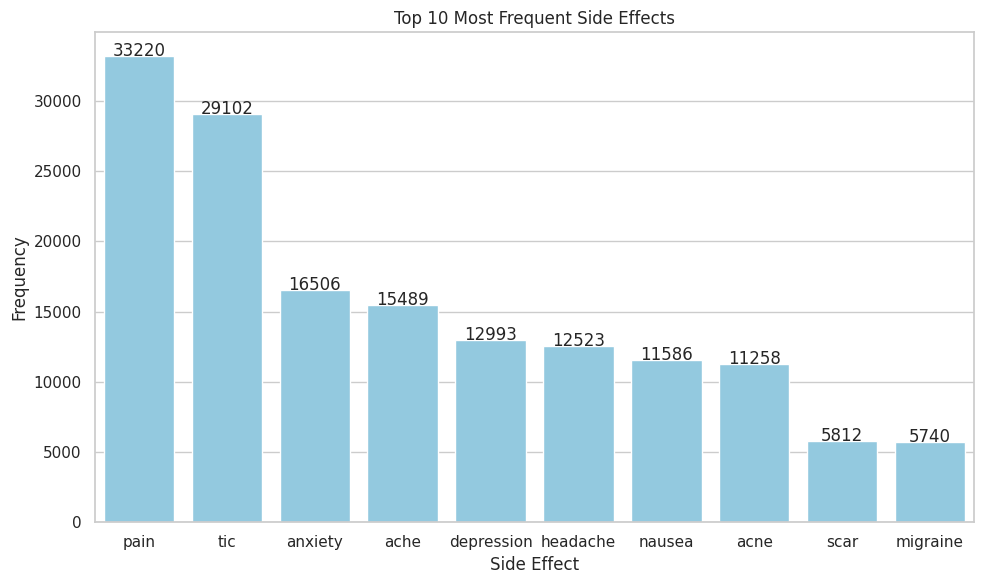

In [104]:
# show the top 10 frequent side effects in a bar chart
top_10_side_effects = side_effect_counts_df.sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Side Effect', y='Count', data=top_10_side_effects, color='skyblue')
plt.title('Top 10 Most Frequent Side Effects')
plt.xlabel('Side Effect')
plt.ylabel('Frequency')

# Add annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            int(height), ha="center")

plt.tight_layout()
plt.show()

#### VADER sentiment label

In [105]:
train_df.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  \
0       May 20, 2012           27   
1     April 27, 2010          192   
2  December 14, 2009           17   
3   November 3, 2015           10   
4  November 27, 2016           37   

                                   normalized_review  \
0  [it, has, no, side, effect, i, take, it, in, c...   
1  [my, son, is, halfway, through, his, fourth, w...   
2  [i, used, to, take, another, oral, contracepti...   
3  [this, is, my, first, time, using, any, form, ...   
4  [suboxone, has, completely, turned, my, life, ...   

                                    processed_review  \
0  [no, side, effect, take, combination, bystolic...   
1  [son, halfway, fourth, week, intuniv, became, ...   
2  [used, take, another, oral, contraceptive, pil...   
3  [first, time, using, form, birth, control, im,...   
4  [suboxone, completely, turned, life, around, f...   

                                   lemmatized_review  
0  [no, side, effect, take, combination, bystolic...  
1  [son, halfway, fourth, week, intuniv, become, ...  
2  [use, take, another, oral, contraceptive, pill...  
3  [first, time, use, form, birth, control, im, g...  
4  [suboxone, completely, turn, life, around, fee...

In [106]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment using VADER
def vader_sentiment_label(text):
    # Get the compound score
    score = sia.polarity_scores(text)['compound']
    # Assign sentiment label based on the compound score
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply VADER to assign sentiment labels and scores
def apply_vader(df, text_column='review'):
    # Calculate VADER compound score
    df['vader_origin_score'] = df[text_column].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    # Assign sentiment labels
    df['origin_sentiment'] = df[text_column].apply(vader_sentiment_label)
    return df

train_df = apply_vader(train_df, text_column='review')
print(train_df[['review', 'vader_origin_score', 'origin_sentiment']].head())

                                              review  vader_origin_score  \
0  "It has no side effect, I take it in combinati...             -0.2960   
1  "My son is halfway through his fourth week of ...              0.8603   
2  "I used to take another oral contraceptive, wh...              0.7962   
3  "This is my first time using any form of birth...              0.7184   
4  "Suboxone has completely turned my life around...              0.9403   

  origin_sentiment  
0         Negative  
1         Positive  
2         Positive  
3         Positive  
4         Positive  


In [112]:
# save origin VADER to csv
columns_to_save = ['review', 'vader_origin_score', 'origin_sentiment']
train_df[columns_to_save].to_csv('train_origin_VADER.csv', index=False)

In [125]:
def adjust_vader_score(df, drug_side_effect_dict, deduction_score=0.2, negation_boost=1.0):
    df['adjusted_vader_score'] = df['vader_origin_score'].copy()
    for index, row in df.iterrows():
        drug_name = row['drugName']
        lemmatized_review = row['lemmatized_review']

        if drug_name in drug_side_effect_dict:
            side_effects = drug_side_effect_dict[drug_name]
            if side_effects:
                for i, word in enumerate(lemmatized_review):
                    if word in side_effects:
                        # Check previous 3 words for negation
                        previous_words = lemmatized_review[max(0, i - 5):i]  # Handle edge cases
                        if any(neg_word in previous_words for neg_word in negation_words):
                            df.loc[index, 'adjusted_vader_score'] += negation_boost  # Boost score
                        else:
                            df.loc[index, 'adjusted_vader_score'] -= deduction_score  # Deduct score
                        break

    return df

# Apply the adjustment
train_df = adjust_vader_score(train_df, drug_side_effect_dict)
print(train_df[['review', 'vader_origin_score', 'adjusted_vader_score', 'origin_sentiment']].head())

                                              review  vader_origin_score  \
0  "It has no side effect, I take it in combinati...             -0.2960   
1  "My son is halfway through his fourth week of ...              0.8603   
2  "I used to take another oral contraceptive, wh...              0.7962   
3  "This is my first time using any form of birth...              0.7184   
4  "Suboxone has completely turned my life around...              0.9403   

   adjusted_vader_score origin_sentiment  
0               -0.2960         Negative  
1                0.8603         Positive  
2                0.7962         Positive  
3                0.7184         Positive  
4                0.7403         Positive  


In [126]:
# tend to use positive and negative more in reality
def update_sentiment(df):
    df['updated_sentiment'] = df['adjusted_vader_score'].apply(
        lambda score: 'Positive' if score > 0.05 else ('Negative' if score < -0.05 else 'Neutral')
    )
    return df

# Apply the sentiment update
train_df = update_sentiment(train_df)
print(train_df[['review', 'vader_origin_score', 'adjusted_vader_score', 'origin_sentiment', 'updated_sentiment']].head())

                                              review  vader_origin_score  \
0  "It has no side effect, I take it in combinati...             -0.2960   
1  "My son is halfway through his fourth week of ...              0.8603   
2  "I used to take another oral contraceptive, wh...              0.7962   
3  "This is my first time using any form of birth...              0.7184   
4  "Suboxone has completely turned my life around...              0.9403   

   adjusted_vader_score origin_sentiment updated_sentiment  
0               -0.2960         Negative          Negative  
1                0.8603         Positive          Positive  
2                0.7962         Positive          Positive  
3                0.7184         Positive          Positive  
4                0.7403         Positive          Positive  


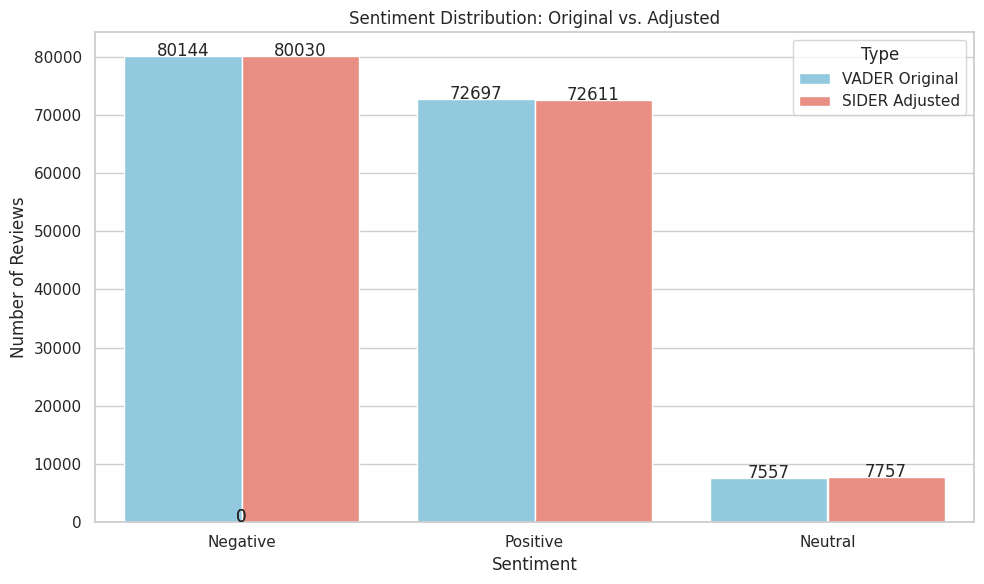

In [134]:
# Use a grouped bar chart to show the adjusted difference
sentiment_counts = pd.DataFrame({
    'Sentiment': train_df['origin_sentiment'].value_counts().index,
    'VADER Original': train_df['origin_sentiment'].value_counts().values,
    'SIDER Adjusted': train_df['updated_sentiment'].value_counts().reindex(train_df['origin_sentiment'].value_counts().index).values
})

# Melt the DataFrame to long format for seaborn
sentiment_counts_melted = pd.melt(sentiment_counts, id_vars=['Sentiment'], var_name='Type', value_name='Count')

# Create the grouped bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Sentiment', y='Count', hue='Type', data=sentiment_counts_melted, palette=['skyblue', 'salmon'])
plt.title('Sentiment Distribution: Original vs. Adjusted')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3,
            int(height), ha="center")

plt.tight_layout()
plt.show()

In [131]:
# show and save difference sentiment's review
different_sentiment_df = train_df[train_df['origin_sentiment'] != train_df['updated_sentiment']]

display(different_sentiment_df)
different_sentiment_df[['rating', 'review', 'vader_origin_score', 'adjusted_vader_score', 'origin_sentiment', 'updated_sentiment']].to_csv('adjusted_difference.csv', index=False)
train_df.to_csv('train_adjusted_VADER.csv', index=False)

Unnamed: 0        drugName                    condition  \
11           75612  L-methylfolate                   Depression   
171         130582  Levonorgestrel                Birth Control   
183          37843       Reclipsen                Birth Control   
195          40776      Leuprolide             Uterine Fibroids   
220          80410           Aleve                    Back Pain   
...            ...             ...                          ...   
161230      121957     Venlafaxine  Generalized Anxiety Disorde   
161239      205544         Pristiq                      Anxiety   
161242      160363       Buspirone                      Anxiety   
161258       34443        Bystolic          High Blood Pressure   
161285      200957     Alcaftadine     Conjunctivitis, Allergic   

                                                   review  rating  \
11      "I have taken anti-depressants for years, with...    10.0   
171     "I am 25 yrs old, no kids and have never been ...    10.0   
183     "Been on Reclipsen for a few months now. Pros-...     6.0   
195     "Received 3-month shot two weeks ago to stop h...     1.0   
220     "I love Aleve! It makes all my lower back pain...    10.0   
...                                                   ...     ...   
161230  "Effexor gave me my life back. I was so with a...     9.0   
161239  "Hot flashes, blisters, heart palpitations, br...     5.0   
161242  "Not good experience AT ALL. I Have anxiety an...     1.0   
161258  "While on Bystolic my feet and arms were numb....     1.0   
161285  "Used this a month ago for allergic conjunctiv...     1.0   

                      date  usefulCount  \
11           March 9, 2017           54   
171            May 7, 2012            1   
183           May 24, 2016            3   
195            May 4, 2016           16   
220        August 12, 2010           41   
...                    ...          ...   
161230   February 22, 2012          160   
161239  September 29, 2012           12   
161242   November 29, 2016            9   
161258       July 18, 2009           25   
161285  September 21, 2014           12   

                                        normalized_review  \
11      [i, have, taken, antidepressants, for, years, ...   
171     [i, am, yrs, old, no, kids, and, have, never, ...   
183     [been, on, reclipsen, for, a, few, months, now...   
195     [received, month, shot, two, weeks, ago, to, s...   
220     [i, love, aleve, it, makes, all, my, lower, ba...   
...                                                   ...   
161230  [effexor, gave, me, my, life, back, i, was, so...   
161239  [hot, flashes, blisters, heart, palpitations, ...   
161242  [not, good, experience, at, all, i, have, anxi...   
161258  [while, on, bystolic, my, feet, and, arms, wer...   
161285  [used, this, a, month, ago, for, allergic, con...   

                                         processed_review  \
11      [taken, antidepressants, years, improvement, m...   
171     [yrs, old, no, kids, never, pregnant, almost, ...   
183     [reclipsen, months, pros, lighter, periods, no...   
195     [received, month, shot, two, weeks, ago, stop,...   
220     [love, aleve, makes, lower, back, pain, disapp...   
...                                                   ...   
161230  [effexor, gave, life, back, anxiety, months, p...   
161239  [hot, flashes, blisters, heart, palpitations, ...   
161242  [not, good, experience, anxiety, depression, u...   
161258  [bystolic, feet, arms, numb, blood, sugars, be...   
161285  [used, month, ago, allergic, conjunctivitis, t...   

                                        lemmatized_review  vader_origin_score  \
11      [take, antidepressant, year, improvement, most...              0.0147   
171     [yrs, old, no, kid, never, pregnant, almost, y...             -0.8472   
183     [reclipsen, month, pro, light, period, no, sto...             -0.9141   
195     [receive, month, shot, two, week, ago, stop, h...          

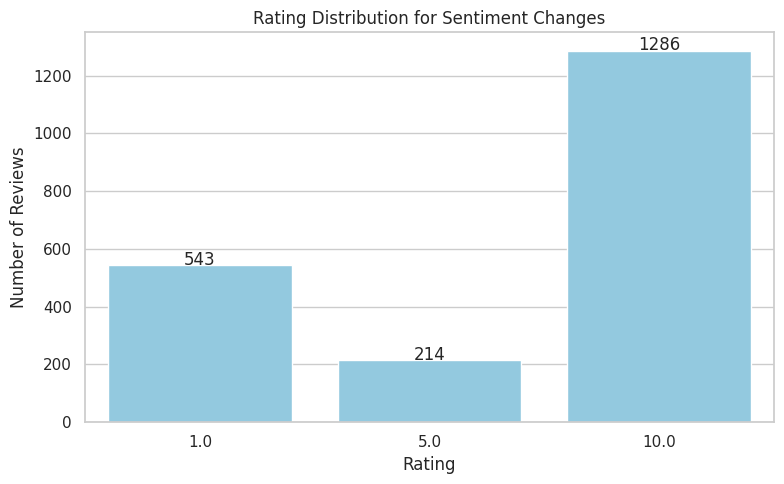

In [136]:
# Calculate rating counts of 1,5,10 in different sentiment
rating_counts = different_sentiment_df['rating'].value_counts().loc[[10, 1, 5]]

plt.figure(figsize=(8, 5))
sns.barplot(x=rating_counts.index, y=rating_counts.values, color='skyblue')
plt.title('Rating Distribution for Sentiment Changes')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2., height + 3,
            int(height),
            ha="center")

plt.tight_layout()
plt.show()
# add common sense:rating=1 -> negative(score -1), rating=10 ->positive(score+1)

#### Extreme rating label
label rating = 1 and 10 to negative and positive

In [139]:
# add extreme rating score as the label method
def label_by_rating(df):
    df['rating_score'] = 0
    df.loc[df['rating'] == 1, 'rating_sentiment_score'] = -1  # Label rating 1 as negative
    df.loc[df['rating'] == 10, 'rating_sentiment_score'] = 1  # Label rating 10 as positive
    return df

def determine_final_sentiment(df):
    df['final_sentiment'] = df['updated_sentiment']
    df.loc[(df['rating_score'] < df['adjusted_vader_score']) & (df['rating_score'] != 0), 'final_sentiment'] = 'Negative'
    df.loc[(df['rating_score'] > df['adjusted_vader_score']) & (df['rating_score'] != 0), 'final_sentiment'] = 'Positive'
    return df

train_df = label_by_rating(train_df)
train_df = determine_final_sentiment(train_df)

print(train_df[['rating', 'review', 'rating_score', 'adjusted_vader_score', 'updated_sentiment', 'final_sentiment']].head())

   rating                                             review  rating_score  \
0     9.0  "It has no side effect, I take it in combinati...             0   
1     8.0  "My son is halfway through his fourth week of ...             0   
2     5.0  "I used to take another oral contraceptive, wh...             0   
3     8.0  "This is my first time using any form of birth...             0   
4     9.0  "Suboxone has completely turned my life around...             0   

   adjusted_vader_score updated_sentiment final_sentiment  
0               -0.2960          Negative        Negative  
1                0.8603          Positive        Positive  
2                0.7962          Positive        Positive  
3                0.7184          Positive        Positive  
4                0.7403          Positive        Positive  


## Feature engineering

In [29]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.sentiment import SentimentIntensityAnalyzer

# Text Vectorization
# Step 1: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(train_df['review'].astype(str))

# Optional: Dimensionality Reduction for TF-IDF using TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
tfidf_reduced = svd.fit_transform(tfidf_matrix)

In [31]:
# Step 2: Sentiment Scoring (Lexicon-Based)
# Using VADER sentiment analyzer
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis on reviews
train_df['vader_sentiment'] = train_df['review'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

In [32]:
train_df['vader_sentiment']

0        -0.2960
1         0.8603
2         0.7962
3         0.7184
4         0.9403
           ...  
161292    0.9561
161293   -0.4767
161294   -0.7430
161295    0.6197
161296    0.6124
Name: vader_sentiment, Length: 160398, dtype: float64

In [33]:
# Step 3: Additional Features
# Review Length
train_df['review_length'] = train_df['review'].astype(str).apply(len)

# Word Count
train_df['word_count'] = train_df['review'].astype(str).apply(lambda x: len(x.split()))

In [34]:
# Step 4: Combine Features into a Final DataFrame
# Combine the reduced TF-IDF features, sentiment scores, and additional features
final_features = np.hstack([
    tfidf_reduced,
    train_df[['vader_sentiment', 'review_length', 'word_count']].values
])

# Labels for feature columns
feature_columns = [f"TFIDF_{i}" for i in range(tfidf_reduced.shape[1])] + ['vader_sentiment', 'review_length', 'word_count']

# Create a DataFrame for final features
final_feature_df = pd.DataFrame(final_features, columns=feature_columns)

In [35]:
display(final_feature_df)

TFIDF_0   TFIDF_1   TFIDF_2   TFIDF_3   TFIDF_4   TFIDF_5   TFIDF_6  \
0       0.028198  0.043957  0.001111 -0.025543  0.005527 -0.006461  0.007257   
1       0.164183  0.062616 -0.069076 -0.051384 -0.074429  0.028607  0.023148   
2       0.260801 -0.132524 -0.161710 -0.032718 -0.123977  0.022608 -0.062670   
3       0.212321 -0.191273 -0.189501 -0.000905  0.022830  0.005624 -0.030837   
4       0.160591  0.029909  0.055808 -0.000501  0.033450  0.000775 -0.006356   
...          ...       ...       ...       ...       ...       ...       ...   
160393  0.078527  0.034273 -0.014779 -0.044285  0.014049  0.002943 -0.014552   
160394  0.080578  0.020644 -0.026331 -0.025277 -0.013274 -0.039347  0.010833   
160395  0.065493  0.028420 -0.033007 -0.026642  0.026890 -0.013409  0.056888   
160396  0.181526  0.000858  0.040609  0.001197  0.000377 -0.014357  0.009664   
160397  0.283703  0.039586  0.050574  0.094508  0.040820 -0.078424  0.047224   

         TFIDF_7   TFIDF_8   TFIDF_9  ...  TFIDF_93  TFIDF_94  TFIDF_95  \
0       0.011492 -0.007969  0.003388  ...  0.006811  0.009295  0.004046   
1       0.023524 -0.014193 -0.003228  ...  0.071040  0.041715  0.016787   
2      -0.014700 -0.004956 -0.119000  ... -0.008903 -0.014465  0.000026   
3      -0.088578  0.005158  0.039237  ...  0.111420 -0.006091  0.070631   
4      -0.013637  0.016585 -0.043144  ... -0.034345 -0.004920 -0.013716   
...          ...       ...       ...  ...       ...       ...       ...   
160393 -0.018645  0.190265  0.047319  ...  0.018651 -0.001179 -0.010695   
160394 -0.044146  0.310852  0.110984  ... -0.016062  0.008545  0.011532   
160395 -0.013180 -0.020501 -0.032718  ... -0.000933 -0.004885  0.000902   
160396 -0.013243 -0.002768 -0.010573  ...  0.029672 -0.023686 -0.072367   
160397  0.006312 -0.018202 -0.096498  ...  0.008447  0.041677 -0.043129   

        TFIDF_96  TFIDF_97  TFIDF_98  TFIDF_99  vader_sentiment  \
0      -0.032897 -0.027611  0.034632 -0.001759          -0.2960   
1      -0.014444  0.040933 -0.019270 -0.067186           0.8603   
2       0.008416  0.024104  0.027394  0.005853           0.7962   
3      -0.074577  0.010247  0.026383 -0.012978           0.7184   
4      -0.000417 -0.012375  0.011820  0.020469           0.9403   
...          ...       ...       ...       ...              ...   
160393 -0.001066  0.049803  0.010647 -0.019176           0.9561   
160394  0.037128 -0.008819  0.006388  0.022968          -0.4767   
160395  0.002095  0.013517 -0.017035 -0.017082          -0.7430   
160396 -0.001350  0.003725  0.001734  0.035551           0.6197   
160397  0.017465 -0.029102 -0.000002 -0.024258           0.6124   

        review_length  word_count  
0                79.0        17.0  
1               741.0       141.0  
2               755.0       134.0  
3               448.0        89.0  
4               719.0       124.0  
...               ...         ...  
160393          689.0       127.0  
160394          262.0        50.0  
160395           95.0        14.0  
160396          772.0       136.0  
160397          347.0        63.0  

[160398 rows x 103 columns]

In [36]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Define side effects ....
side_effects = ["nausea", "headache", "fatigue", "dizziness", "rash", "anxiety"]

def label_sentiment(text):
    # VADER sentiment score
    score = sia.polarity_scores(text)['compound']

    # Side effect detection
    negative_flag = any(side_effect in text.lower() for side_effect in side_effects)

    # Define thresholds and rules
    if score > 0.05 and not negative_flag:
        return 'Positive'
    elif score < -0.05 or negative_flag:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment labeling
train_df['sentiment'] = train_df['review'].astype(str).apply(label_sentiment)

# Check labeled data
print(train_df[['review', 'sentiment']].head())

                                              review sentiment
0  "It has no side effect, I take it in combinati...  Negative
1  "My son is halfway through his fourth week of ...  Positive
2  "I used to take another oral contraceptive, wh...  Positive
3  "This is my first time using any form of birth...  Positive
4  "Suboxone has completely turned my life around...  Positive


In [37]:
# Select the desired columns
review_sentiment_df = train_df[['review', 'sentiment']]

# Save the selected columns to CSV
review_sentiment_df.to_csv('review_sentiment.csv', index=False)